# Random Forest Variance Threshold

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [4]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [5]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [6]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [7]:
y_train = train['rating_category']
y_test = test['rating_category']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', rf_classifier)
])

In [11]:
param_grid_rf = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__n_estimators': [50, 100],
    'classification__max_depth': [None, 10, 20],
    'classification__min_samples_split': [2, 5],
    'classification__min_samples_leaf': [1, 2],
    'classification__max_features': ['auto', 'sqrt']
}

In [12]:
from sklearn.model_selection import GridSearchCV

# Create the GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1, verbose=1, error_score='raise')

# Fit it to the data
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classification__max_depth': [None, 10, 20],
                         'classification__max_features': ['auto', 'sqrt'],
                         'classification__min_samples_leaf': [1, 2],
                         'classification__min_samples_split': [2, 5],
                         'classification__n_estimators': [50, 100],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=1)

In [13]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set (useful for ROC curve, etc.)
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score (mean cross-validated score of the best_estimator)
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search_rf.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_rf_vt = grid_search_rf.best_estimator_.predict(X_test)
y_score_rf_vt = grid_search_rf.best_estimator_.predict_proba(X_test)

In [27]:
# Execute the function and store the results
results_rf_vt = post_grid_search_analysis(grid_search_rf, X_test, y_test)

# Print the results
print(f"Random Forest (Variance Threshold) Best Parameters: {results_rf_vt['Best Parameters']}")
print(f"Random Forest (Variance Threshold) Best Score: {results_rf_vt['Best Score']}")
print(f"Random Forest (Variance Threshold) Test Accuracy: {results_rf_vt['Test Accuracy']}")


Random Forest (Variance Threshold) Best Parameters: {'classification__max_depth': None, 'classification__max_features': 'auto', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 100, 'variance_threshold__threshold': 0.0009}
Random Forest (Variance Threshold) Best Score: 0.6119148936170212
Random Forest (Variance Threshold) Test Accuracy: 0.6225772655840754


In [33]:
import joblib

# Save the trained model
joblib.dump(grid_search_rf.best_estimator_, '/content/drive/MyDrive/data/rf_vt_model.pkl')

['/content/drive/MyDrive/data/rf_vt_model.pkl']

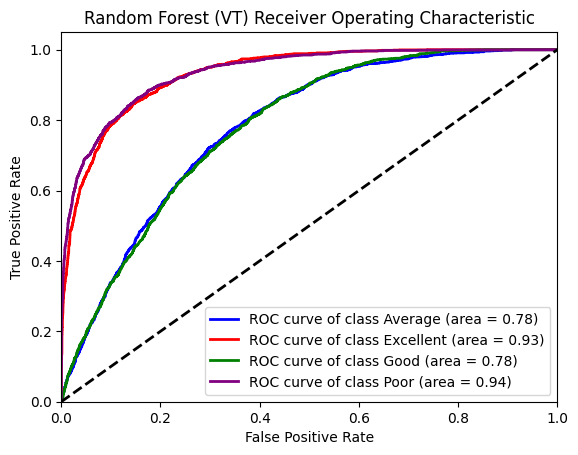

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_rf_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest (VT) Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [29]:
from sklearn.metrics import classification_report

# Generate classification report
rf_vt_report = classification_report(y_test, y_pred_rf_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
rf_vt_report_df = pd.DataFrame(rf_vt_report).transpose()

In [30]:
rf_vt_report_df

,precision,recall,f1-score,support
Average,0.505196,0.460769,0.481961,1899.000000
Excellent,0.738235,0.712259,0.725014,1762.000000
Good,0.512445,0.530303,0.521221,1980.000000
Poor,0.730394,0.788972,0.758554,1995.000000
accuracy,0.622577,0.622577,0.622577,0.622577
macro avg,0.621568,0.623076,0.621688,7636.000000
weighted avg,0.619685,0.622577,0.620489,7636.000000


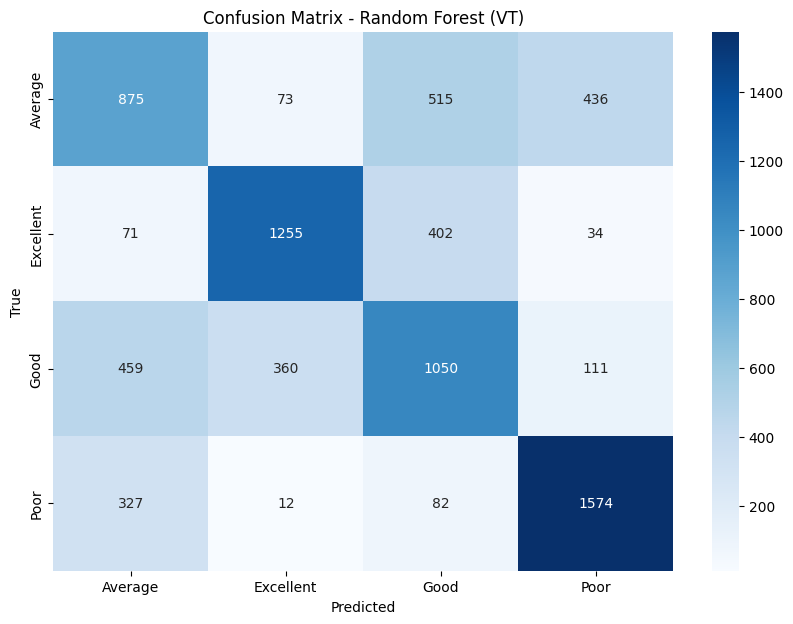

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_rf_vt = confusion_matrix(y_test, y_pred_rf_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest (VT)')
plt.show()